# Text Analysis (Adapted from Garrent Gaut's 2016 Tutorial)

---

## Introdution

Text Analysis is great for summarizing or getting useful information out of a large amount of text stored in documents. This opens up the oppurtunity of using text data alongside more conventional data sources (e.g, surveys and administrative data). The goal of text analysis is to take a large corpus of complex and unstructured text data and extract important and meaningful messages in a comprehensible meaningful way. 

Text Analysis can help with the following tasks:

* **Searches and informationa retrieval**: Help find relevant information in large databases such a systematic literature review. 

* **Clustering and text categorization**: Techniques like clustering modeling can summarize a large corpus of text by finding the most important phrases. 

* **Text Summarization**: Create category-sensitive text summaries of a large corpus of text. 

* **Machine Translation**: Translate from one language to another. 


## Glossary of Terms

* **Tokenize**: Tokenization is the process by which text is sepearated into meaningful terms or phrases. Often separating sentences using punctuation. 
* **Stemming**: Stemming is a type of text normalization where words that have different forms but the essential meaning are normalized to the original dictionary form of a word. For example "go," "went," and "goes" all stem from the lemma "go." 
* **TFIDF**: TFIDF (Term frequency-inverse document frequency) is an example of feature enginnering where the most important words are extracted by taking account their frequency in documents and the entire corpus of documents as a whole.
* **Topic Modelling**: Topic modeling is an unsupervised learning method where the keywords that describe the topics in a large corpus of text are discovered. 
* **LDA**: LDA (latent Dirichlet allocation) is a type of topic modelling algorithm. 
* **Stop Words**: Stop words are words that have little semantic meaning like prepositions, articles and common nouns. 

## Table of Contents
 - [Data Source](#Data-Source)
 - Data_Cleaning
 - Unsupervised Learning: Topic Modelling
 - Supervised Learning: LDA
 
 ---

In [1]:
%pylab inline 
import nltk
import ujson
import re
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn import preprocessing
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import SnowballStemmer

nltk.download('stopwords')

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/avishek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def load_reddit(fname, ls_subreddits=[], MIN_CHAR=30):
    """
    Loads Reddit Comments from a json file based on 
    whether they are in the selected subreddits and 
    have more than the MIN_CHARACTERS
    
    Parameters
    ----------
    fname: str
        filename
    ls_subreddits: ls[str]
        list of subreddits to select from 
    MIN_CHAR: int
        minimum number of characters necessary to select
        a comment
        
    Returns
    -------
    corpus: ls[str]
        list of selected reddit comments
    subreddit_id: array[int]
        np.array of indices that match with the ls_subreddit
        index 
    """
    corpus = []
    subreddit_id = []
    with open(fname, 'r') as infile:
        for line in infile:
            dict_reddit_post =  ujson.loads(line)
            subreddit = dict_reddit_post['subreddit']
            n_characters = len( dict_reddit_post['body'] )
            
            if ls_subreddits: #check that the list is not empty
                in_ls_subreddits = subreddit in ls_subreddits
            else:
                in_ls_subreddits = True
            
            grter_than_min = n_characters > MIN_CHAR
            
            if ( grter_than_min and in_ls_subreddits ):
                corpus.append(dict_reddit_post['body'])
                subreddit_id.append(subreddit)
                
    return np.array(corpus), np.array(subreddit_id)

In [3]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

## Load Data

### Data Source: Reddit Comments from May 2015 in JSON format

In [4]:
#grab data from the following subreddits
ls_subreddits = ['SuicideWatch', 'depression']
[corpus, subreddit_id] = load_reddit('./data/RC_2015-05.json', ls_subreddits, MIN_CHAR=30)

## Preprocess the data

In [5]:
RE_PREPROCESS = r'\W+|\d+' #matches are non-word chracters and digits to be replaced with spaces.  
#get rid of punctuation and make everything lowercase
processes_corpus = [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus]
Counter(subreddit_id)

Counter({'SuicideWatch': 12609, 'depression': 24683})

# Tokenize and stem and create features

In [6]:
nltk.download('stopwords')
ANALYZER = "word"
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
NGRAM_RANGE = (0,2)
MIN_DF = 0.01
MAX_DF = 0.8

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/avishek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=(0,2),
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

In [8]:
NORM = None
SMOOTH_IDF = True
SUBLINEAR_IDF = True
USE_IDF = True

In [9]:
transformer = TfidfTransformer(norm = NORM,
                               smooth_idf = SMOOTH_IDF,
                               sublinear_tf = True)

In [10]:
#get the bag-of-words from the vectorizer and
#then use TFIDF to limit the tokens found throughout the text 
start_time = time.time()
bag_of_words = vectorizer.fit_transform( processes_corpus ) #using all the data on for generating features!! Bad!
if USE_IDF:
    tfidf = transformer.fit_transform(bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 14.56s


# Superivsed Learning: Identify the Subreddit Section

In [11]:
#split the data into training and testing sets. 
#refactor this in the test train-split
train_set_size = int(0.8*len(subreddit_id))
train_idx = np.arange(0,train_set_size)
test_idx = np.arange(train_set_size, 
                     len(subreddit_id))

In [12]:
test_subreddit_id = subreddit_id[test_idx]

In [14]:
test_corpus = corpus[test_idx]

In [16]:
print('Training Labels', Counter(subreddit_id[train_idx]))
print('Testing Labels', Counter((subreddit_id[test_idx])))

Training Labels Counter({'depression': 19382, 'SuicideWatch': 10451})
Testing Labels Counter({'depression': 5301, 'SuicideWatch': 2158})


In [19]:
X = tfidf

In [20]:
le = preprocessing.LabelEncoder()

In [21]:
le.fit(subreddit_id)

LabelEncoder()

In [22]:
subreddit_id_binary = le.transform(subreddit_id)

In [23]:
#make clear what are the features and what are the labels 
clf = LogisticRegression(penalty='l1')
mdl = clf.fit(X[train_idx], 
              subreddit_id_binary[train_idx])
y_score = mdl.predict_proba( X[test_idx])

# Evalution of the Supervised Model

In [24]:
auc = roc_auc_score( subreddit_id_binary[test_idx], y_score[:,1])
print("{0:.2f}".format(auc))

0.65


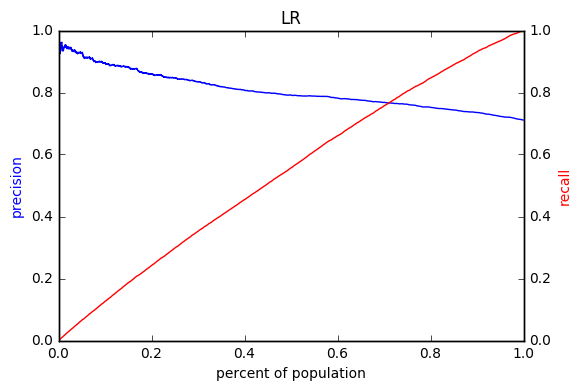

In [25]:
 plot_precision_recall_n(subreddit_id_binary[test_idx], y_score[:,1], 'LR')

# Feature Importances 

In [26]:
coef = mdl.coef_.ravel()

dict_feature_importances = dict( zip(features, coef) )
orddict_feature_importances = OrderedDict( 
                                sorted(dict_feature_importances.items(), key=lambda x: x[1]) )

ls_sorted_features  = list(orddict_feature_importances.keys())

num_features = 5
subreddit0_features = ls_sorted_features[:5] #SuicideWatch
subreddit1_features = ls_sorted_features[-5:] #depression
print('SuicideWatch',subreddit0_features)
print('depression', subreddit1_features)

SuicideWatch ['suicide', 'please', 'talked', 'suicidal', 'hospital']
depression ['helps', 'psychiatrist', 'depressed', 'effects', 'depression']


# See the predictions 

In [27]:
#maybe do something with this crazy indexing: this is python not C!
num_comments = 5
subreddit0_comment_idx = y_score[:,1].argsort()[:num_comments] #SuicideWatch
subreddit1_comment_idx = y_score[:,1].argsort()[-num_comments:] #depression
#convert back to the indices of the original dataset
top_comments_testing_set_idx = np.concatenate([subreddit0_comment_idx, 
                                               subreddit1_comment_idx])


In [29]:
for ind in top_comments_testing_set_idx:
    print(ind, test_subreddit_id[ind])

5596 SuicideWatch
4227 SuicideWatch
7179 SuicideWatch
3224 SuicideWatch
2602 SuicideWatch
4814 depression
5730 depression
3775 depression
6499 depression
706 SuicideWatch


In [30]:
#these are the 5 comments the model is most sure of 
for i in top_comments_testing_set_idx:
    print(
        u"""{}:{}\n---\n{}\n===""".format(test_subreddit_id[i],
                                          y_score[i,1],
                                          test_corpus[i]))

SuicideWatch:0.010054852718690535
---
It sounds like you're exhausted on many levels and are losing hope or have lost hope. I'm so sorry. 

For what it's worth, it's striking that you give equal weight in your post to your personal struggles and your existential despair at the state of the world. That's pretty remarkable - it speaks to your empathy. You are not worthless. I think that you want to help people. You say that you don't even know why you try - but it sounds like you do know. You care about the world so much that it hurts. Helping people gives life meaning, right? And sometimes jerks may deny that or try to take that from you, but we all have to fight them. 

I know that I can't imagine the added pain of being trans in a hostile world, though some of this, I get. I'm queer too and not in a good situation right now and it sounds like you've got something eating disordered type stuff going on - that certainly makes the world a harder place to live in. There is help out there t

# Unsupervised Learning 

In [3]:
N_TOPICS = 50
N_TOP_WORDS = 10

In [4]:
start = time.time()
all_corpus, all_subreddit_id = load_reddit('./data/RC_2015-05.json',MIN_CHAR=30)
end = time.time()
print('Loading takes {}s'.format(end-start))

MemoryError: 

In [32]:
N_TOPICS = 50
N_TOP_WORDS = 10 

def load_all_reddit_mh( directory = '2015', filenames = ['RC_2015-01', 'RC_2015-02', 
                                    'RC_2015-03', 'RC_2015-04', 'RC_2015-05'], MIN_CHARACTERS = 50):
    """
    Function to import Reddit comments from mental health forums from May 2015 
    
    params: 
        str filename: name of file to open 
        int MIN_CHARACTERS: thresholds comments we load by comment length (in characters) 
    """
    corpus = []
    subreddit_id = []
    subreddits = []
    for filename in filenames: 
        with open(directory + '/' + filename, 'r') as f:
            for line in f:
                json_dict = ujson.loads(line)
                subreddit = json_dict['subreddit']
                comment = json_dict['body']
                if len(comment) > MIN_CHARACTERS:
                    corpus.append(comment)
                    if subreddit in subreddits:
                        pass
                    else: 
                        subreddits.append(subreddit)
                    subreddit_id.append(subreddits.index(subreddit))
    return [corpus, subreddit_id, subreddits]


In [33]:
start = time.time()
[corpus_all, subreddit_id_all, subreddits_all] = load_all_reddit_mh(directory = '.', filenames = ['./data/RC_2015-05.json'],
                                                                    MIN_CHARACTERS = 50)

In [34]:
# Get rid of punctuation and set to lowercase  
start = time.time()
processed_corpus_all = [ re.sub( RE_PREPROCESS, ' ', comment).lower() for comment in corpus_all]

bag_of_words_all = vectorizer.fit_transform( processed_corpus_all )
end = time.time() 
print("Processing took {}s".format(end - start)) # takes ~62s for 1 file, 401s for 5 files 

Processing took 69.3504536151886s


In [35]:
print(Counter(subreddit_id_all), len(subreddit_id_all))

Counter({0: 23621, 1: 23157, 7: 16857, 4: 12351, 2: 11835, 3: 10655, 11: 8046, 15: 6806, 6: 4684, 5: 3026, 12: 2864, 9: 2772, 10: 2528, 16: 2209, 18: 1711, 19: 1621, 13: 976, 8: 928, 14: 793, 26: 597, 24: 590, 25: 383, 20: 382, 23: 364, 30: 358, 22: 305, 34: 302, 31: 284, 32: 273, 17: 229, 38: 221, 21: 142, 33: 70, 43: 38, 35: 32, 28: 25, 27: 23, 37: 18, 42: 17, 36: 13, 41: 11, 44: 9, 29: 7, 46: 6, 40: 5, 39: 3, 45: 1, 47: 1, 48: 1, 49: 1}) 142151


In [36]:
start = time.time()
lda = LatentDirichletAllocation( n_topics = N_TOPICS )
lda.fit_transform( bag_of_words_all )
end = time.time() 
print("Processing took {}s".format(end- start)) # takes ~72s for 1 file, ~445s for 5 files 

/home/avishek/py3venv/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Processing took 802.6678080558777s


In [42]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx, ", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("\nTopics in LDA model:")

print_top_words(lda, features, N_TOP_WORDS)


Topics in LDA model:


IndexError: list index out of range

# The Comments Most Likely to be taken from each subreddit

Return to [TOC](#Table-of-Contents)